# 🧠 Learning the Inverse Problem

Welcome to the fourth notebook! Here we'll train a neural network to predict force field configurations directly from target trajectories.

## What You'll Learn

1. **Amortized Optimization**: Why learning beats per-instance optimization
2. **Data Generation**: Creating training data from random simulations
3. **Model Architecture**: Encoder-decoder for trajectory → fields
4. **End-to-End Training**: Backpropagating through physics
5. **Evaluation**: Measuring model performance

## The Key Insight

Instead of running gradient descent for each new trajectory, we train a neural network to predict good force configurations in a single forward pass!

Let's learn to solve the inverse problem! 🚀


In [ ]:
# Setup and imports
import sys
sys.path.insert(0, '..')

import jax
import jax.numpy as jnp
from jax import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle
from tqdm.notebook import tqdm

# Import our modules
from physics.state import PhysicsState, SimulationConfig
from physics.fields import WindField
from physics.simulator import simulate_positions_only, trajectory_loss_same_length

from model.model import InverseModel, create_model
from model.training import (
    Trainer, 
    TrainingConfig,
    generate_training_sample,
    generate_training_dataset,
    evaluate_model,
)

# Plotting defaults
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")
print("✅ All imports successful!")


JAX version: 0.8.2
Devices: [CpuDevice(id=0)]
✅ All imports successful!


## Part 1: Why Learn Instead of Optimize?

### The Problem with Per-Instance Optimization

For each new target trajectory, gradient descent requires:
- ~100-500 iterations
- Multiple forward simulations
- Gradient computations

This is **slow** for a game where we need real-time AI responses!

### Amortized Optimization

**Idea**: Train a neural network once, then use it to predict solutions instantly.

| Approach | Per-Trajectory Cost | Total Cost (N trajectories) |
|----------|--------------------|-----------------------------|
| Gradient Descent | O(iterations × simulation) | O(N × iterations × simulation) |
| Neural Network | O(forward pass) | O(training) + O(N × forward pass) |

For large N, the neural network wins!


## Part 2: Generating Training Data

We need pairs of (trajectory, force_field_config) for training. Strategy:
1. Generate random force field configurations
2. Simulate to get trajectories
3. Use these pairs for training


In [8]:
# Configuration for data generation
config = SimulationConfig(dt=0.01, num_steps=150, bounds=((-5, 5), (-5, 5)))

# Generate a single sample to see what it looks like
key = random.PRNGKey(42)
sample = generate_training_sample(key, config, field_type='wind')

print("Sample contents:")
print(f"  Trajectory shape: {sample['trajectory'].shape}")
print(f"  Initial position: {sample['initial_position']}")
print(f"  Initial velocity: {sample['initial_velocity']}")
print(f"  Wind center: {sample['field_params']['wind_center']}")
print(f"  Wind strength: {sample['field_params']['wind_strength']:.2f}")


Sample contents:
  Trajectory shape: (150, 2)
  Initial position: [-0.9394784 -1.3732758]
  Initial velocity: [1.0072278 1.3286021]
  Wind center: [-0.05493951 -1.5713198 ]
  Wind strength: 11.67


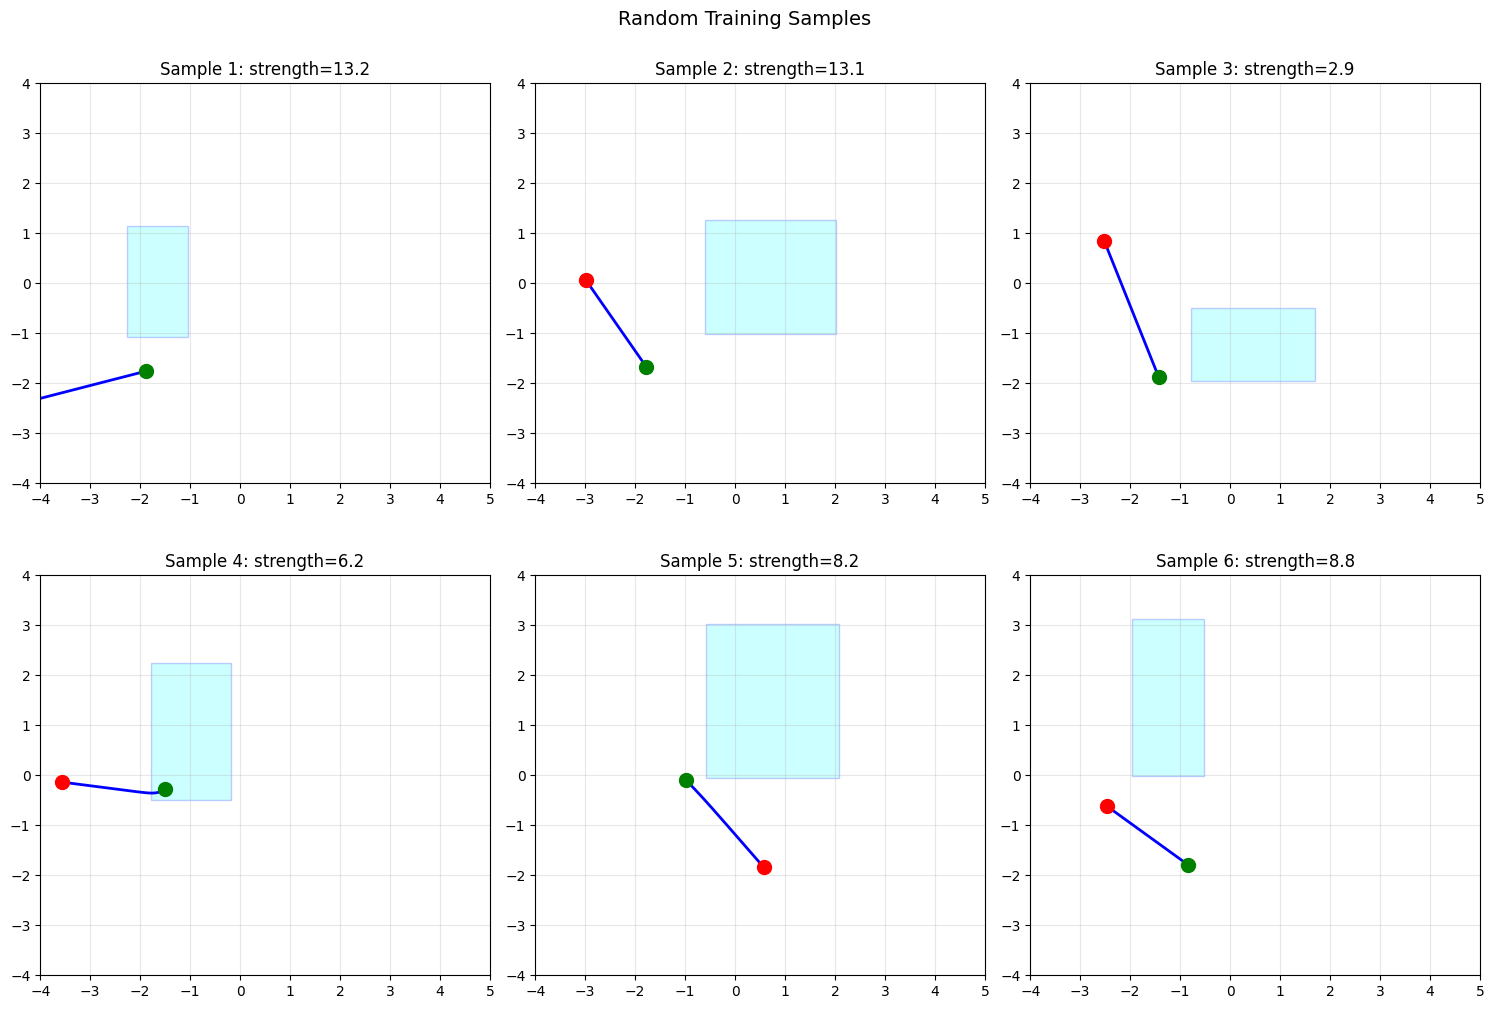

In [9]:
# Visualize a few training samples
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

keys = random.split(random.PRNGKey(123), 6)
for i, (ax, k) in enumerate(zip(axes, keys)):
    sample = generate_training_sample(k, config)
    traj = sample['trajectory']
    params = sample['field_params']
    
    # Plot trajectory
    ax.plot(traj[:, 0], traj[:, 1], 'b-', linewidth=2)
    ax.scatter([traj[0, 0]], [traj[0, 1]], c='green', s=100, zorder=5)
    ax.scatter([traj[-1, 0]], [traj[-1, 1]], c='red', s=100, zorder=5)
    
    # Draw wind region
    center = params['wind_center']
    size = params['wind_size']
    rect = Rectangle(center - size/2, size[0], size[1], 
                     fill=True, facecolor='cyan', alpha=0.2, edgecolor='blue')
    ax.add_patch(rect)
    
    ax.set_xlim(-4, 5)
    ax.set_ylim(-4, 4)
    ax.set_aspect('equal')
    ax.set_title(f'Sample {i+1}: strength={float(params["wind_strength"]):.1f}')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Random Training Samples', y=1.02, fontsize=14)
plt.show()


In [10]:
# Generate training and validation datasets
print("Generating training data...")
train_data = generate_training_dataset(500, config, seed=42)  # Small for demo
print("Generating validation data...")
val_data = generate_training_dataset(100, config, seed=12345)

print(f"\n✅ Generated {len(train_data)} training samples")
print(f"✅ Generated {len(val_data)} validation samples")


Generating training data...


Generating data: 100%|██████████| 500/500 [00:50<00:00,  9.84it/s]


Generating validation data...


Generating data: 100%|██████████| 100/100 [00:13<00:00,  7.30it/s]


✅ Generated 500 training samples
✅ Generated 100 validation samples


## Part 3: Model Architecture

Our model has two parts:
1. **Encoder**: Trajectory (N×2) → Latent vector (D)
2. **Decoder**: Latent vector → Force field parameters


In [11]:
# Create the model
model = create_model(
    encoder_type='transformer',  # Options: 'cnn', 'transformer', 'pointnet'
    hidden_dim=64,
    latent_dim=32,
    max_wind=1,    # Predict 1 wind field
    max_vortex=0,
    max_point=0,
)

# Test forward pass
sample_trajectory = jnp.ones((1, config.num_steps, 2))
rng = random.PRNGKey(0)
variables = model.init(rng, sample_trajectory, training=False)

print(f"Model initialized!")
print(f"Number of parameters: {sum(x.size for x in jax.tree_util.tree_leaves(variables['params'])):,}")


Model initialized!
Number of parameters: 163,176


In [12]:
# Test prediction on a sample
test_traj = train_data[0]['trajectory'][None, ...]  # Add batch dim
prediction = model.apply(variables, test_traj, training=False)

print("Prediction structure:")
print(f"  Wind mask: {prediction.wind_mask.shape}")
print(f"  Wind centers: {prediction.wind_centers.shape}")
print(f"  Wind sizes: {prediction.wind_sizes.shape}")
print(f"  Wind directions: {prediction.wind_directions.shape}")
print(f"  Wind strengths: {prediction.wind_strengths.shape}")

print(f"\nPredicted wind strength: {float(prediction.wind_strengths[0, 0]):.2f}")
print(f"Actual wind strength: {float(train_data[0]['field_params']['wind_strength']):.2f}")


Prediction structure:
  Wind mask: (1, 1)
  Wind centers: (1, 1, 2)
  Wind sizes: (1, 1, 2)
  Wind directions: (1, 1, 2)
  Wind strengths: (1, 1)

Predicted wind strength: -6.30
Actual wind strength: 9.53


## Part 4: Training with Physics Loss

The key innovation: we train by simulating the predicted fields and comparing trajectories!

```
trajectory → encoder → decoder → predicted_fields → simulate → predicted_trajectory
                                                                        ↓
                                                              loss = ||predicted - target||²
```

Gradients flow backward through the **entire** pipeline, including the physics simulation!


In [13]:
# Create trainer with physics-based loss
training_config = TrainingConfig(
    num_epochs=30,       # More epochs for better results
    batch_size=16,
    learning_rate=1e-3,
    loss_type='physics', # Use physics simulation in the loss!
    log_every=5,
    eval_every=10,
    sim_dt=config.dt,
    sim_steps=config.num_steps,
)

trainer = Trainer(model, training_config, rng_seed=42)
print("✅ Trainer initialized")


✅ Trainer initialized


In [14]:
# Train the model!
print("Starting training...")
history = trainer.train(train_data, val_data, verbose=True)
print("\n✅ Training complete!")


Starting training...


Training: 100%|██████████| 30/30 [32:14<00:00, 64.47s/it, Epoch 25: train_loss=0.9239, val_loss=0.9942] 


✅ Training complete!


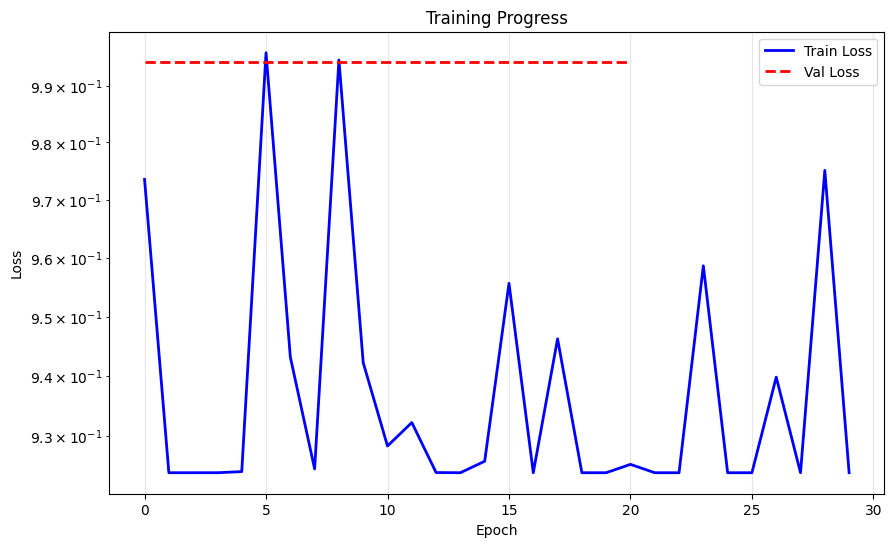

In [15]:
# Plot training progress
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(history['train_loss'], 'b-', linewidth=2, label='Train Loss')
if len(history['val_loss']) > 0:
    val_epochs = [i * training_config.eval_every for i in range(len(history['val_loss']))]
    ax.plot(val_epochs, history['val_loss'], 'r--', linewidth=2, label='Val Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training Progress')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_yscale('log')
plt.show()


## Part 5: Evaluating the Model

Let's see how well the model predicts force fields for new trajectories!


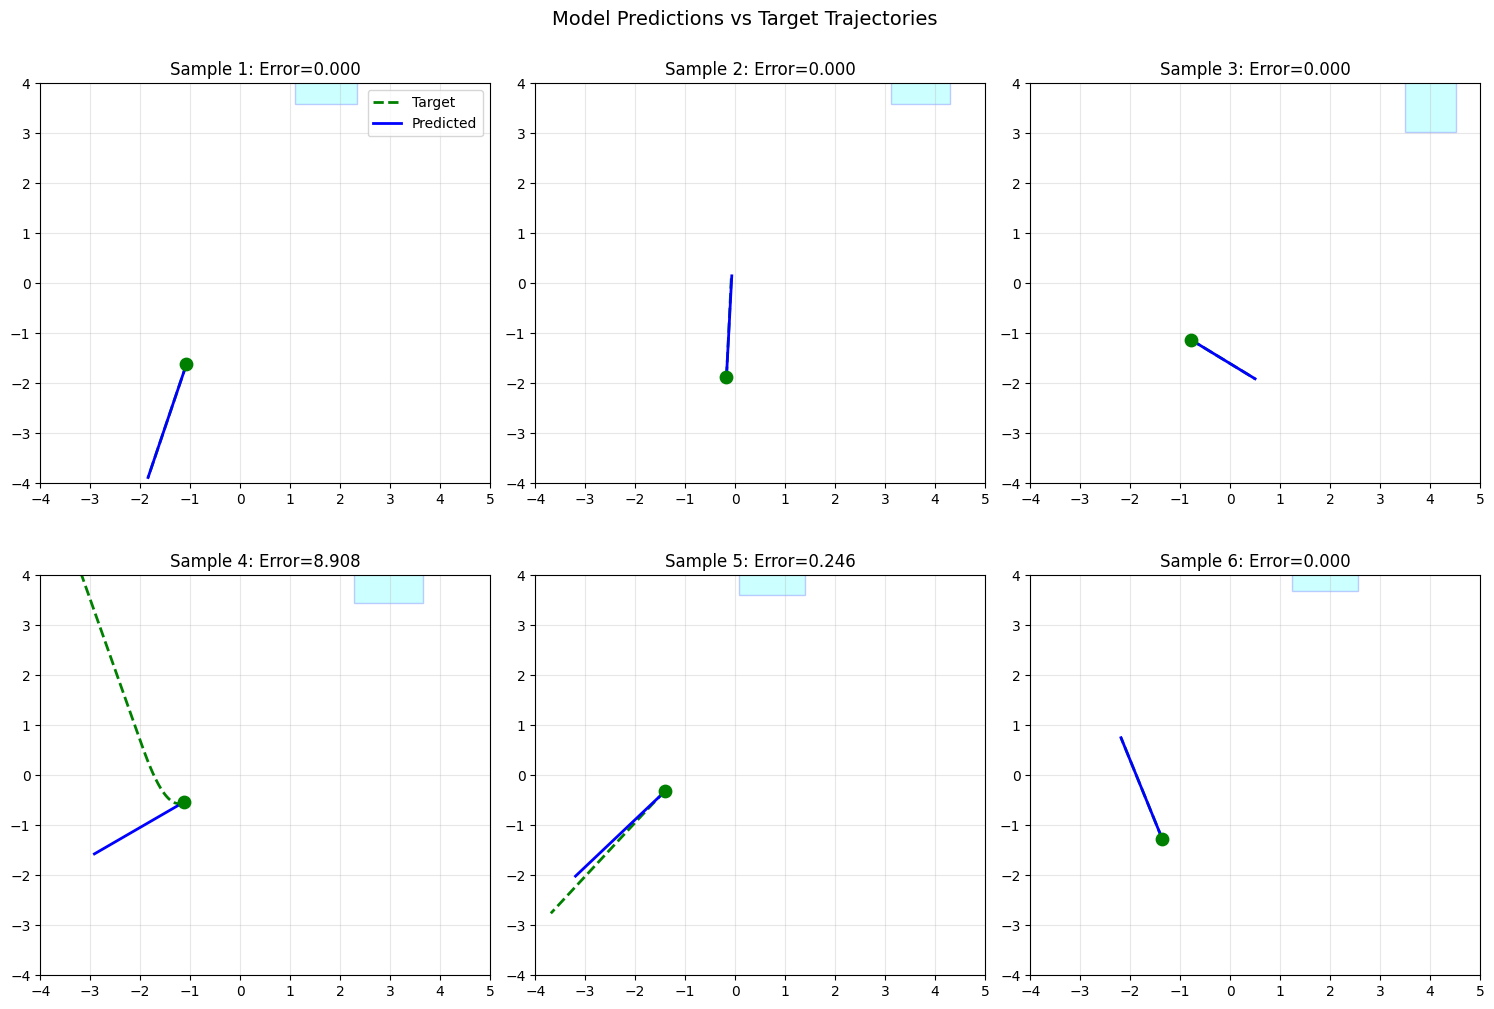

In [17]:
# Visualize predictions on validation samples
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    sample = val_data[i]
    target_traj = sample['trajectory']
    
    # Get prediction
    prediction = trainer.predict(target_traj)
    
    # Create predicted wind field
    pred_wind = WindField(
        center=prediction.wind_centers[0, 0],
        size=prediction.wind_sizes[0, 0],
        direction=prediction.wind_directions[0, 0],
        strength=float(prediction.wind_strengths[0, 0]),
        softness=0.1,
    )
    
    # Simulate with predicted field
    state = PhysicsState(
        position=sample['initial_position'],
        velocity=sample['initial_velocity'],
        time=0.0,
    )
    pred_traj = simulate_positions_only(state, [pred_wind], config)
    
    # Plot
    ax.plot(target_traj[:, 0], target_traj[:, 1], 'g--', linewidth=2, label='Target')
    ax.plot(pred_traj[:, 0], pred_traj[:, 1], 'b-', linewidth=2, label='Predicted')
    
    # Draw predicted wind region
    rect = Rectangle(
        pred_wind.center - pred_wind.size/2, 
        pred_wind.size[0], pred_wind.size[1],
        fill=True, facecolor='cyan', alpha=0.2, edgecolor='blue'
    )
    ax.add_patch(rect)
    
    ax.scatter([target_traj[0, 0]], [target_traj[0, 1]], c='green', s=80, zorder=5)
    
    # Compute error
    error = float(trajectory_loss_same_length(pred_traj, target_traj))
    ax.set_title(f'Sample {i+1}: Error={error:.3f}')
    ax.set_xlim(-4, 5)
    ax.set_ylim(-4, 4)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.suptitle('Model Predictions vs Target Trajectories', y=1.02, fontsize=14)
plt.show()


## Summary

In this notebook, we learned:

1. **Amortized Optimization**: Training a network is more efficient than per-instance optimization
2. **Data Generation**: Create (trajectory, field_config) pairs by simulation
3. **Physics Loss**: Backpropagate through differentiable simulation
4. **End-to-End Training**: The entire pipeline is differentiable!

## Key Insights

- The model learns to **generalize** across trajectories
- Physics loss ensures the model produces **physically valid** solutions
- Single forward pass replaces hundreds of optimization steps

## Next Steps

In the next notebook, we'll:
- Scale up with more data and larger models
- Add curriculum learning (simple → complex trajectories)
- Explore architecture improvements

See you in **05_scaling_up.ipynb**! 🚀
